# Food Deserts Model Implementation

Group Members: Nathan Deron, Jeremiah Humes, Devraj Kori, Meredith Meadows

## Setup

In [16]:
# Import packages
from gurobipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
#Load in the data
vacant_lots = pd.read_csv('data/vacant_lots_centroid.csv')
travel_times = pd.read_csv('data/travel_times_100.csv')
travel_costs = pd.read_csv('data/travel_costs_100.csv')
supermarkets = pd.read_csv('data/supermarkets.csv')
addresses = pd.read_csv('data/pittsburgh_100.csv')

In [18]:
#Extract the relevant variables and put into numpy arrays
D = travel_costs.iloc[:,2:].to_numpy(dtype = float)
T = travel_times.iloc[:,2:].to_numpy(dtype = float)

## Define Parameters

In [22]:
#Create generators for variable indexes
households = range(100) #indexed by i
store_type = range(3) #not sure about this one yet
location = range(100) #indexed by k, 0-60 = grocery stores, 61-99 = vacant lot

#Create O[k] - convenience store identifier
#Logic: len(supermarkets) is number of stores, get a list of ones of this length
#number of lots is number of columns in either travel_times or travel_costs minus number of stores
#since they are all columns in the same matrix, make a list of zeros of this size
#Add both lists together
number_of_stores = len(supermarkets)
number_of_lots = T.shape[1] - number_of_stores
O = ([1]*number_of_stores) + ([0]*number_of_lots)

#Create E[k] - the cost of building a store at location k
#estimated cost of building the store + the cost of acquiring the lot
#Construction cost = 17,000 sq ft * $78.57 per sq ft
constr_cost = 17000 * 78.57

#Get the lot prices
lot_prices = list(vacant_lots['LOCALLAND__asmt'])

#Create E[k] based on O[k] - doesn't matter what price for non-vacant areas set to
E = [constr_cost + int(lot_prices[i]) if O[i] == 0 else 1 for i in range(len(O)) ]

#Define the lambda penalty

#Generate store preference for each household
#Separate by each third of the income distribution
addresses['prefs'] = pd.qcut(addresses['simulated_income'], 3, labels = [1, 2, 3])

lambda_penalty = 20
lamb = []
for i in households:
    pref = [lambda_penalty if addresses['prefs'][i] != j else 0 for j in store_type]
    lamb.append(pref)
lamb = np.array(lamb)

# Construct Z[i,k] = 1 if household travels time exceeds 20 minutes, 0 otherwise
# travel time is in hours, so convert 20 minutes to hours
cutoff = 20
cutoff_hours = cutoff/60

#Take travel times, replace any value greater than the cuttoff with 1, 0 otherwise
Z = np.where(T > cutoff_hours, 1, 0)

#Construct the delta matrix
#Difference between cutoff and travel time
Z = (T - cutoff_hours)*Z

#Finally, convert Z to minutes
Z = Z*60

#Set Delta penalty
delta = 2


## Gurobi Implementation - Decision Vars, Objective Terms, and Constraints

In [25]:
#Initialize the model
m = Model(name = 'Food_Deserts')

#Define decision variables
X = m.addVars(store_type, location, vtype = GRB.BINARY, name = 'X_jk')
Y = m.addVars(households, store_type, location, vtype = GRB.BINARY, name = 'Y_ijk')

#Define the objective terms
#Total Construction cost
BUILD_COST = LinExpr()

for j in store_type:
    for k in location:
        BUILD_COST += X[j,k]*E[k]
        
#Total Access cost
ACCESS_COST = LinExpr()

for j in store_type:
    for i in households:
        for k in location:
            ACCESS_COST += Y[i,j,k] * (D[i,k] + Z[i,k]*delta + lamb[i,j])

#Define the constraints

#Can only build on vacant land

for j in store_type:
    for k in location:
        m.addConstr(X[j,k] <= 1 - O[k])
        
#Can only shop at existing or built store
for i in households:
    for j in store_type:
        for k in location:
            m.addConstr(Y[i,j,k] <= O[k] + X[j,k])

#must build 5 stores
m.addConstr( sum(X[j,k] for j in store_type for k in location) >= 5)

#Customer assignment
for i in households:
    m.addConstr( sum(Y[i,j,k] for j in store_type for k in location) == 1 )

## Add Goals Weights, Set Objective, and Solve

In [45]:
#Initialize an empty list to store tuples
#tuple = (construction cost, access cost)
results = []

#Define alpha values to use
step = 0.05
alphas = np.arange(0, 1+step, step)

for alpha in alphas:
    m.setObjective((alpha*BUILD_COST) + ((1-alpha)*ACCESS_COST), GRB.MINIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    results.append((BUILD_COST.getValue(), ACCESS_COST.getValue()))
    print('Alpha: ', str(alpha))
    print('Optimal Construction Cost: ', str(round(BUILD_COST.getValue(), 2)))
    print('Optimal Access Cost: ', str(round(ACCESS_COST.getValue(), 2)))
    print('Total Objective Function Value: ', str(round(m.objVal, 2)))
    print()

Alpha:  0.0
Optimal Construction Cost:  160015830.0
Optimal Access Cost:  42543.02
Total Objective Function Value:  42543.02

Alpha:  0.05
Optimal Construction Cost:  6692350.0
Optimal Access Cost:  45262.56
Total Objective Function Value:  377616.93

Alpha:  0.1
Optimal Construction Cost:  6692350.0
Optimal Access Cost:  45262.56
Total Objective Function Value:  709971.3

Alpha:  0.15000000000000002
Optimal Construction Cost:  6688250.0
Optimal Access Cost:  45965.47
Total Objective Function Value:  1042308.15

Alpha:  0.2
Optimal Construction Cost:  6688250.0
Optimal Access Cost:  45965.47
Total Objective Function Value:  1374422.37

Alpha:  0.25
Optimal Construction Cost:  6688250.0
Optimal Access Cost:  45965.47
Total Objective Function Value:  1706536.6

Alpha:  0.30000000000000004
Optimal Construction Cost:  6684550.0
Optimal Access Cost:  47469.12
Total Objective Function Value:  2038593.38

Alpha:  0.35000000000000003
Optimal Construction Cost:  6684150.0
Optimal Access Cost:  

# Results - Plot Pareto Frontier

Text(0, 0.5, 'Total Access Cost (USD)')

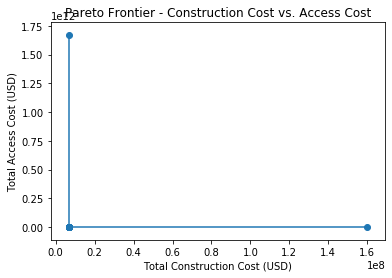

In [46]:
#Get x and y vectors from the results
x = [BUILD_COST for (BUILD_COST, ACCESS_COST) in results]
y = [ACCESS_COST for (BUILD_COST, ACCESS_COST) in results]

#Plot the results
plt.plot(x,y)
plt.scatter(x,y)
plt.title('Pareto Frontier - Construction Cost vs. Access Cost')
plt.xlabel('Total Construction Cost (USD)')
plt.ylabel('Total Access Cost (USD)')